
=== Classification Report: AC ===
              precision    recall  f1-score   support

         OFF       1.00      1.00      1.00       116
          ON       1.00      1.00      1.00        34

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



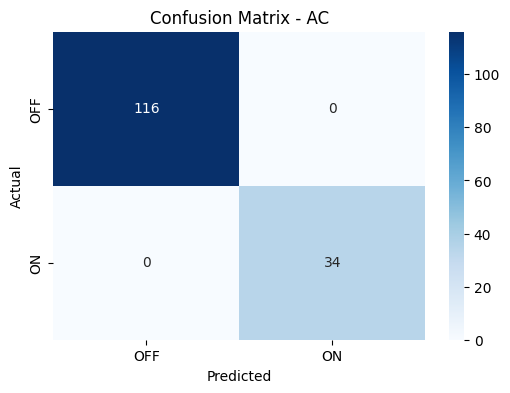


=== Classification Report: Humidifier (threshold=0.7) ===
              precision    recall  f1-score   support

         OFF       1.00      1.00      1.00        91
          ON       1.00      1.00      1.00        59

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



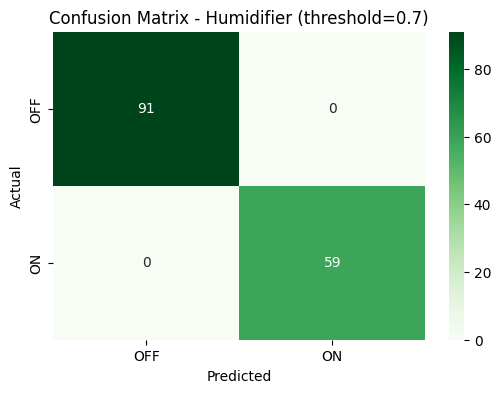

Rata-rata probabilitas ON humidifier: 0.393


In [7]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Fungsi untuk evaluasi dan visualisasi
def evaluasi_model(y_true, y_pred, label_encoder, title, cmap):
    print(f"\n=== Classification Report: {title} ===")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, zero_division=0))
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap=cmap,
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# === Training model AC ===
data_temp = pd.read_csv('dataset_temp.csv').dropna()
le_ac = LabelEncoder()
data_temp['kondisi_ac_enc'] = le_ac.fit_transform(data_temp['kondisi_ac'])

X_temp = data_temp[['temperature']]
y_temp = data_temp['kondisi_ac_enc']

X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

model_ac = GaussianNB()
model_ac.fit(X_train_temp, y_train_temp)
joblib.dump(model_ac, 'model_ac.pkl')

pred_temp = model_ac.predict(X_test_temp)
evaluasi_model(y_test_temp, pred_temp, le_ac, 'AC', 'Blues')

# === Training model Humidifier ===
data_humid = pd.read_csv('dataset_humid.csv').dropna()
le_hum = LabelEncoder()
data_humid['kondisi_humidifier_enc'] = le_hum.fit_transform(data_humid['kondisi_humidifier'])

X_humid = data_humid[['humidity']]
y_humid = data_humid['kondisi_humidifier_enc']

X_train_hum, X_test_hum, y_train_hum, y_test_hum = train_test_split(X_humid, y_humid, test_size=0.3, random_state=42)

model_hum = GaussianNB()
model_hum.fit(X_train_hum, y_train_hum)
joblib.dump(model_hum, 'model_hum.pkl')

# Prediksi probabilitas + threshold untuk humidifier
probs_hum = model_hum.predict_proba(X_test_hum)
idx_on = list(model_hum.classes_).index(1)
threshold = 0.7
pred_hum_thresholded = (probs_hum[:, idx_on] >= threshold).astype(int)

evaluasi_model(y_test_hum, pred_hum_thresholded, le_hum, f'Humidifier (threshold={threshold})', 'Greens')

print(f"Rata-rata probabilitas ON humidifier: {probs_hum[:, idx_on].mean():.3f}")


In [ ]:
# === Import Firebase & Model ===
import time
import joblib
import pandas as pd
import firebase_admin
from firebase_admin import credentials, db

# === Load Trained Models ===
model_ac = joblib.load('model_ac.pkl')          # model yang pakai fitur temperature
model_humidifier = joblib.load('model_hum.pkl') # model yang pakai fitur humidity

# === Firebase Initialization ===
database_url = 'https://temperature-project-80671-default-rtdb.firebaseio.com/'
if not firebase_admin._apps:
    cred = credentials.Certificate('serviceAccountKey.json')
    firebase_admin.initialize_app(cred, {'databaseURL': database_url})

sensor_ref = db.reference('/', url=database_url)

# === Threshold untuk humidifier ===
threshold_hum = 0.7  # bisa kamu sesuaikan

def polling_and_predict(interval_seconds=5):
    print("Mulai polling data sensor dari Firebase...\nTekan CTRL + C untuk berhenti.")
    try:
        while True:
            data = sensor_ref.get()
            if data:
                temp = data.get('temp')
                humid = data.get('humid')

                if temp is not None and humid is not None:
                    # Data frame untuk model AC: hanya temperature
                    df_temp = pd.DataFrame([[temp]], columns=['temperature'])
                    # Data frame untuk model humidifier: hanya humidity
                    df_hum = pd.DataFrame([[humid]], columns=['humidity'])

                    # Prediksi AC (langsung klasifikasi)
                    pred_ac = model_ac.predict(df_temp)[0]

                    # Prediksi probabilitas humidifier, lalu threshold
                    prob_hum = model_humidifier.predict_proba(df_hum)[0]
                    idx_on = list(model_humidifier.classes_).index(1)  # indeks kelas 'ON'
                    pred_hum = 1 if prob_hum[idx_on] >= threshold_hum else 0

                    # Ubah hasil prediksi ke label string (OFF/ON)
                    label_ac = 'ON' if pred_ac == 1 else 'OFF'
                    label_hum = 'ON' if pred_hum == 1 else 'OFF'

                    # Tampilkan hasil
                    print(f"[Data Sensor] Temp: {temp}°C, Humid: {humid}%")
                    print(f"[Prediksi] AC: {label_ac} | Humidifier: {label_hum}\n")

                    # Kirim ke Firebase
                    db.reference('/output', url=database_url).set({
                        'prediksi_ac': label_ac,
                        'prediksi_humid': label_hum
                    })
                else:
                    print("⚠️ Data sensor tidak lengkap")
            else:
                print("⚠️ Data sensor kosong")

            time.sleep(interval_seconds)
    except KeyboardInterrupt:
        print("✅ Polling dihentikan oleh user.")

# === Jalankan Polling ===
polling_and_predict(5)


Mulai polling data sensor dari Firebase...
Tekan CTRL + C untuk berhenti.
[Data Sensor] Temp: 28.9375°C, Humid: 41.9%
[Prediksi] AC: ON | Humidifier: OFF

[Data Sensor] Temp: 28.9375°C, Humid: 41.8%
[Prediksi] AC: ON | Humidifier: OFF

[Data Sensor] Temp: 28.875°C, Humid: 41.8%
[Prediksi] AC: ON | Humidifier: OFF

[Data Sensor] Temp: 28.875°C, Humid: 41.8%
[Prediksi] AC: ON | Humidifier: OFF

[Data Sensor] Temp: 28.8125°C, Humid: 41.8%
[Prediksi] AC: ON | Humidifier: OFF

[Data Sensor] Temp: 28.75°C, Humid: 41.8%
[Prediksi] AC: ON | Humidifier: OFF

[Data Sensor] Temp: 28.75°C, Humid: 41.8%
[Prediksi] AC: ON | Humidifier: OFF

[Data Sensor] Temp: 28.75°C, Humid: 41.6%
[Prediksi] AC: ON | Humidifier: OFF

[Data Sensor] Temp: 28.75°C, Humid: 41.7%
[Prediksi] AC: ON | Humidifier: OFF

[Data Sensor] Temp: 28.75°C, Humid: 41.6%
[Prediksi] AC: ON | Humidifier: OFF

[Data Sensor] Temp: 28.6875°C, Humid: 41.7%
[Prediksi] AC: ON | Humidifier: OFF

[Data Sensor] Temp: 28.6875°C, Humid: 41.7%
[Pr